In [6]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_tqdm import TQDMNotebookCallback
# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

In [7]:
with open('/nfshome/sandbox/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])

In [8]:
with open('/nfshome/sandbox/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [9]:
def encode_seq(x,mapping,min_length=0):
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))

def decode_seq(x,mapping):
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [10]:
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)

In [11]:
dataX = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp

dataY = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

In [12]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [13]:
nlines = 50
X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(50, 76, 71)
(50, 76, 71)
(50, 75, 71)
(50, 75, 71)


In [18]:

hidden_size = X.shape[1]*3
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# 2 input layers and an output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 228), (None, 273600      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 228),  273600      input_4[0][0]                    
                                                                 lstm_3[0][1]                     
          

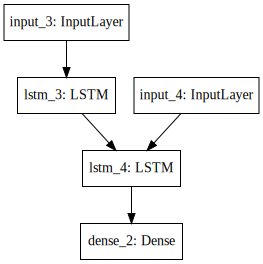

In [19]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
batch_size = nlines # only one pattern...
epochs = 1000
history = model.fit([X,preY], postY,
batch_size=batch_size,
epochs=epochs,
verbose=0,
callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

50/50 [==============================] - 2s 31ms/step
Accuracy: 74.4266676902771 %


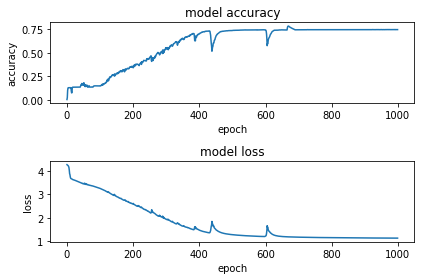

In [21]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


In [22]:
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
[decoder_input] + decoder_states_input,
[decoder_output] + decoder_states)

In [23]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [24]:
# What should we see?
print('Input:', text[i])
print('Output:', text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [26]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))


Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: However little known the feelings or views of such a man may be on his
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: first entering a neighbourhood, this truth is so well fixed in the minds
Txt: of the surrounding families, that he is considered the rightful property
Net: of the surrounding families, that he is considered the rightful property
Txt: of some one or other of their daughters.
Net: of some one or other of their daughters.
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Txt: Netherfield Park is let at last?"
Net:  an eechad an  eresngl ougle my thi he
Txt: Mr. Bennet replied that he had not.
Net: Mr. Bennet replied that he had not.
Txt: "But it is," ret

In [27]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nlines):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)


Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: Howerltt tken whee and sit hive ofre i  emut nnto
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: first entering a neighbourhood, this truth is so well fixed in the minds
Txt: of the surrounding families, that he is considered the rightful property
Net: of the surrounding families, that he is considered the rightful property
Txt: of some one or other of their daughters.
Net: of some one or other of their daughters.
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: go, mere on thet ickeonthttri hat le ine etile u
Txt: Netherfield Park is let at last?"
Net: newcomers. Indeed you must go, for it will be impossible for _us_ to
Txt: Mr. Bennet replied that he had not.
Net: visit him if you do not."
Txt: "But it is," returned she; "for Mrs. Long

<h4> Problem 2 </h4>

In [31]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_tqdm import TQDMNotebookCallback
# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

In [ ]:
# Preprocessing - grab lines from the file
with open('/nfshome/sandbox/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
words = []
for i in range(len(lines)):
    if lines[i] != '':
        words = lines[i].split()
        text = text + words
# Paragraphs are separated by blank
# lines -> just drop those lines...
#text = []
#for i in range(len(lines)):
 #   if lines[i] != '':
  #      text = text + [lines[i]]
min_length = max([len(i) for i in text])

In [32]:
len(text)

364317

In [33]:
max(len(i) for i in text)+2

30

In [34]:
# Unique characters - precalculated
with open('/nfshome/sandbox/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split()
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [35]:
len(itos)

71

In [36]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))
def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)


In [37]:
# An ecoding-decoding cycle on the first line...
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It'

In [38]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp


In [39]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [40]:
nlines = 500
X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)


(500, 30, 71)
(500, 30, 71)
(500, 29, 71)
(500, 29, 71)


In [63]:
hidden_size = X.shape[1]*3
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c =  encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# 2 input layers and an output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
model.summary()


# it had an error that I couldn't save encoder_output since it was in a loop or conditional.
# Initializer for variable lstm_27/kernel/ is from inside a control-flow construct, such as a loop or conditional.
# When creating a variable inside a loop or conditional, use a lambda as the initializer.

ValueError: Initializer for variable lstm_27/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.